# Discrete Fourier Transform

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nu = 5
t = linspace(0, 2*pi, nu)
F = fft.fft(np.eye(nu))
print(np.round(F, 1))

[[ 1. +0.j   1. -0.j   1. +0.j   1. -0.j   1. +0.j ]
 [ 1. +0.j   0.3-1.j  -0.8-0.6j -0.8+0.6j  0.3+1.j ]
 [ 1. +0.j  -0.8-0.6j  0.3+1.j   0.3-1.j  -0.8+0.6j]
 [ 1. +0.j  -0.8+0.6j  0.3-1.j   0.3+1.j  -0.8-0.6j]
 [ 1. +0.j   0.3+1.j  -0.8+0.6j -0.8-0.6j  0.3-1.j ]]


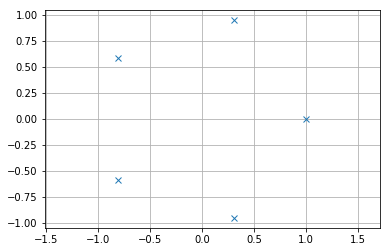

In [3]:
lam = exp(-1j*2*pi/nu)
z = lam**range(nu)
plt.plot(real(z), imag(z), 'x')
np.round(z, 2)
grid()
axis('equal');

In [4]:
lam = exp(-1j*2*pi/nu)
F2 = np.zeros((nu, nu), dtype=complex)
ak_vect = np.hstack([np.arange(0, nu//2 + 1), -np.arange(nu//2, 0, -1)])
j_vect = np.arange(nu)

for k in ak_vect:
    for j in j_vect:
        F2[j, k] = lam**(k*j)
print(np.round(F2, 1))

[[ 1. +0.j   1. +0.j   1. +0.j   1. +0.j   1. +0.j ]
 [ 1. +0.j   0.3-1.j  -0.8-0.6j -0.8+0.6j  0.3+1.j ]
 [ 1. +0.j  -0.8-0.6j  0.3+1.j   0.3-1.j  -0.8+0.6j]
 [ 1. +0.j  -0.8+0.6j  0.3-1.j   0.3+1.j  -0.8-0.6j]
 [ 1. +0.j   0.3+1.j  -0.8+0.6j -0.8-0.6j  0.3-1.j ]]


In [5]:
np.max(np.abs(F2 - F))

3.510833468576701e-16

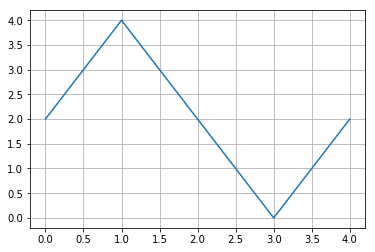

In [6]:
x = 2*sin(nu*t) + 2
plt.plot(x)
plt.grid()

In [7]:
fft.ifft(x) - np.conj(fft.fft(x))/nu

array([ 0.00000000e+00+0.00000000e+00j, -5.55111512e-17-1.11022302e-16j,
        5.55111512e-17+2.77555756e-17j,  5.55111512e-17-2.77555756e-17j,
       -5.55111512e-17+1.11022302e-16j])

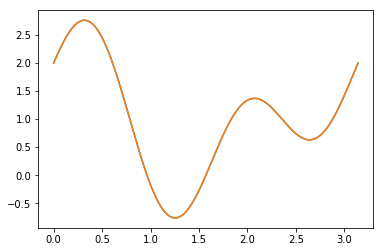

In [8]:
t = np.linspace(0, pi, 4096)
plt.plot(t, (np.real(fft.ifft([1, 1], 4096) + np.imag(fft.ifft([0, 0, 1], 4096))) *4096))
plt.plot(t, (np.real(fft.fft([1, 1], 4096) - np.imag(fft.fft([0, 0, 1], 4096)))))

In [9]:
np.linalg.inv(F) - np.conj(F)

array([[-0.8      -8.19754230e-19j, -0.8      +0.00000000e+00j,
        -0.8      +0.00000000e+00j, -0.8      +2.77555756e-17j,
        -0.8      -2.77555756e-17j],
       [-0.8      -1.23537354e-17j, -0.2472136-7.60845213e-01j,
         0.6472136-4.70228202e-01j,  0.6472136+4.70228202e-01j,
        -0.2472136+7.60845213e-01j],
       [-0.8      +9.80660865e-18j,  0.6472136-4.70228202e-01j,
        -0.2472136+7.60845213e-01j, -0.2472136-7.60845213e-01j,
         0.6472136+4.70228202e-01j],
       [-0.8      -1.20504739e-17j,  0.6472136+4.70228202e-01j,
        -0.2472136-7.60845213e-01j, -0.2472136+7.60845213e-01j,
         0.6472136-4.70228202e-01j],
       [-0.8      +1.54173549e-17j, -0.2472136+7.60845213e-01j,
         0.6472136+4.70228202e-01j,  0.6472136-4.70228202e-01j,
        -0.2472136-7.60845213e-01j]])

Text(0, 0.5, '$|a_k|$')

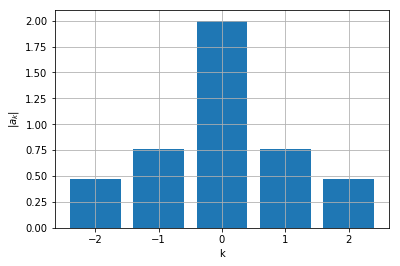

In [10]:
ak = np.conj(F.dot(x))/nu
plt.bar(ak_vect, abs(ak))
plt.grid()
plt.xlabel('k')
plt.ylabel('$|a_k|$')

Text(0, 0.5, '$|a_k|$')

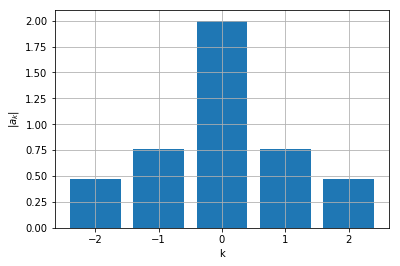

In [11]:
ak2 = inv(F2).dot(x)
plt.bar(ak_vect, abs(ak2))
plt.grid()
plt.xlabel('k')
plt.ylabel('$|a_k|$')

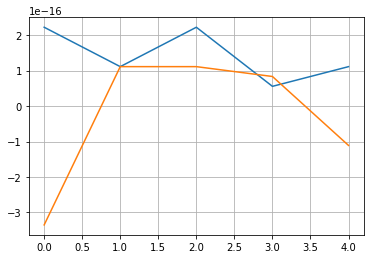

In [12]:
plot(np.real(ak - ak2))
plot(np.imag(ak - ak2))

plt.grid()

# Reconstructing Sinusoids from FFT/IFFT

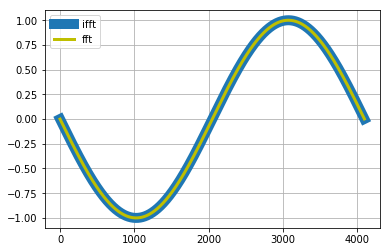

In [13]:
plot(-4096*imag(fft.ifft([0, 1], 4096)), linewidth=10, label='ifft');
plot(imag(fft.fft([0, 1], 4096)), linewidth=3, color='y', label='fft');
plt.legend()
plt.grid()

# Nyquist Sampling Theorem/ Aliasing

initial sample time: 0.1 seconds
sampling interval: 6.9 seconds


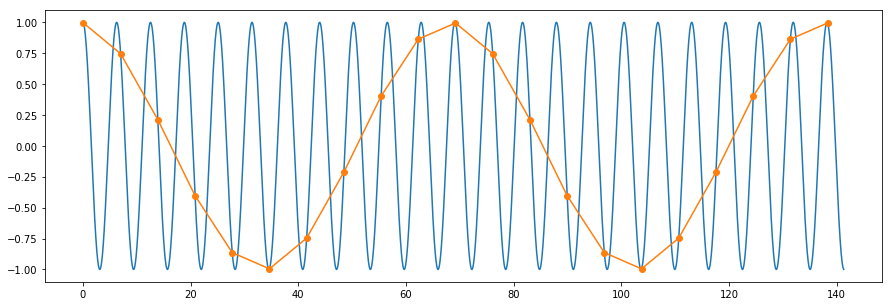

In [14]:
t = arange(0, 45*pi, pi/100)
T = 2*pi
dt = 1.1*T
t0 = 0.1

ts = arange(t0, 45*pi, dt)

figure(figsize=(15, 5))
plot(t, cos(t))
plot(ts, cos(ts), 'o-')

print('initial sample time: {:0.2g} seconds'.format(t0))
print('sampling interval: {:0.2g} seconds'.format(dt))

# Image Processing 

In [15]:
def add_noise(data, n):
    data2 = np.copy(data)
    for i in range(n):
        j = np.random.randint(0, data2.shape[0])
        k = np.random.randint(0, data2.shape[1])
        data2[j, k] = int(255*np.random.rand())
    return data2

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def analyze_image(file, noise=0, n=30):
    img = cv2.imread(file, 0)
    img = add_noise(img, noise)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift_orig = np.copy(fshift)
    mag_spectrum = 20*np.log(np.abs(fshift_orig))

    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2
    fshift_high = np.copy(fshift)
    fshift_high[crow-n:crow+n, ccol-n:ccol+n] = 0
    mag_spectrum_high = 20*np.log(np.abs(fshift_high) + 1e-20)
    f_ishift = np.fft.ifftshift(fshift_high)
    img_high = np.fft.ifft2(f_ishift)
    img_high = np.real(img_high)

    img_low = img - img_high
    mag_spectrum_low = 20*np.log(np.abs(fshift_orig - fshift_high) + 1e-20)
    
    vmin = 0
    vmax = 255

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image')
    plt.axis('tight')

    plt.subplot(122),plt.imshow(mag_spectrum, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')
    plt.show()

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img_high, cmap = 'gray', vmin=-vmax, vmax=vmax)
    plt.title('Image after High Pass Filter')
    plt.axis('tight')

    plt.subplot(122), plt.imshow(mag_spectrum_high, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img_low, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.title('Image after Low Pass Filter')
    plt.axis('tight')

    plt.subplot(122), plt.imshow(mag_spectrum_low, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')


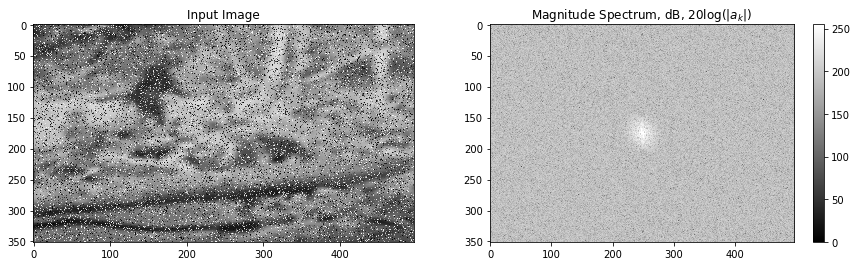

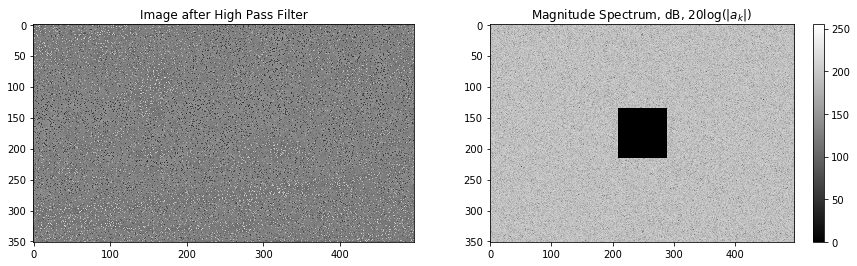

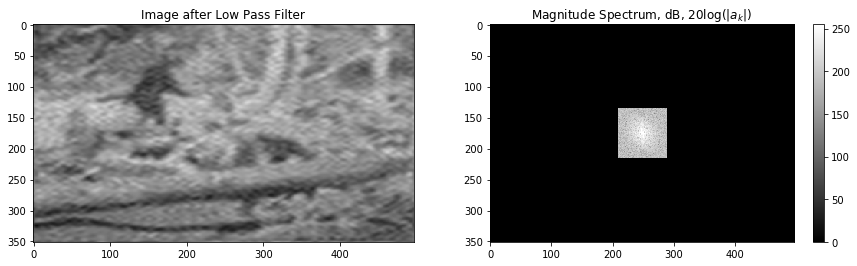

In [17]:
analyze_image('./data/bigfoot.png', noise=50000, n=40)

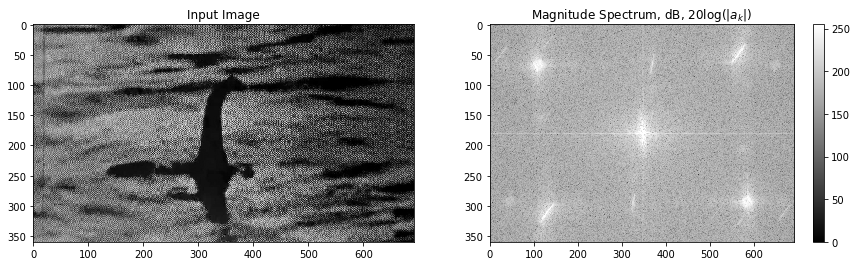

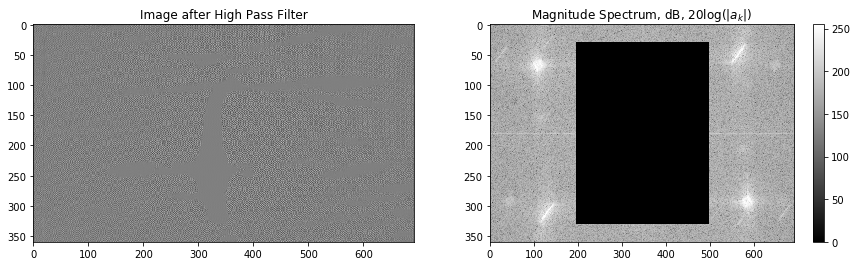

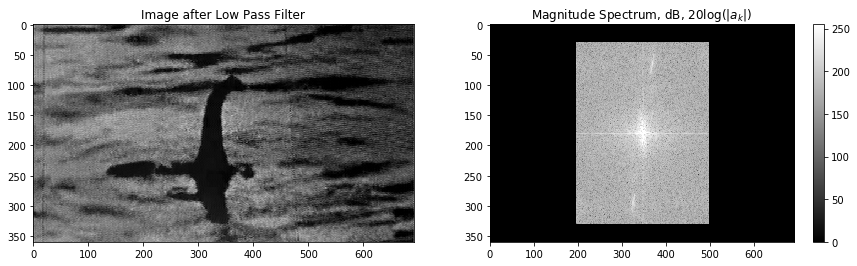

In [18]:
analyze_image('./data/nessy.jpg', noise=0, n=150)